## Assignment 3: Time-Series Data

## Name: Sowmya Thokala



In [46]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-07 01:32:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.233.232, 54.231.161.120, 52.217.44.222, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.233.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12.94M  45.9MB/s    in 0.3s    

2024-11-07 01:32:54 (45.9 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

###Inspecting data - Jena weather dataset

In [47]:
import os

file_path = os.path.join("jena_climate_2009_2016.csv")

with open(file_path) as file:
    file_data = file.read()

rows = file_data.split("\n")
column_headers = rows[0].split(",")
data_rows = rows[1:]

print(column_headers)
print(len(data_rows))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


###Parsing the data

In [48]:
import numpy as np

temp_data = np.zeros((len(data_rows),))
data_matrix = np.zeros((len(data_rows), len(column_headers) - 1))

for index, row in enumerate(data_rows):
    row_values = [float(value) for value in row.split(",")[1:]]
    temp_data[index] = row_values[1]
    data_matrix[index, :] = row_values[:]


###Temperature timeseries plotting

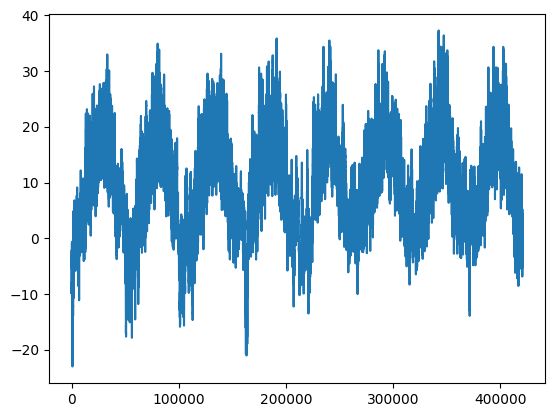

In [49]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp_data)), temp_data)

###Plotting the first 10 days of the temperature timeseries

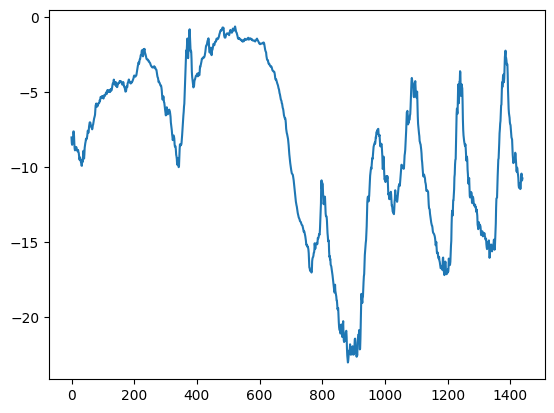

In [50]:
plt.plot(range(1440), temp_data[:1440])

###Counting the number of samples used for each data split

In [51]:
train_sample_count = int(0.5 * len(data_matrix))
val_sample_count = int(0.25 * len(data_matrix))
test_sample_count = len(data_matrix) - train_sample_count - val_sample_count

print("train_sample_count:", train_sample_count)
print("val_sample_count:", val_sample_count)
print("test_sample_count:", test_sample_count)


train_sample_count: 210225
val_sample_count: 105112
test_sample_count: 105114


###Data preparation

##Normalizing the data

In [52]:
train_mean = data_matrix[:train_sample_count].mean(axis=0)
data_matrix -= train_mean
train_std = data_matrix[:train_sample_count].std(axis=0)
data_matrix /= train_std


In [53]:
import numpy as np
from tensorflow import keras

sequence_data = np.arange(10)
sample_dataset = keras.utils.timeseries_dataset_from_array(
    data=sequence_data[:-3],
    targets=sequence_data[3:],
    sequence_length=3,
    batch_size=2,
)

for features, labels in sample_dataset:
    for j in range(features.shape[0]):
        print([int(value) for value in features[j]], int(labels[j]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


###Dividing the datasets for training, testing and validation

In [54]:
sampling_interval = 6
seq_length = 120
target_delay = sampling_interval * (seq_length + 24 - 1)
batch_sz = 256

training_dataset = keras.utils.timeseries_dataset_from_array(
    data_matrix[:-target_delay],
    targets=temp_data[target_delay:],
    sampling_rate=sampling_interval,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_sz,
    start_index=0,
    end_index=train_sample_count
)

validation_dataset = keras.utils.timeseries_dataset_from_array(
    data_matrix[:-target_delay],
    targets=temp_data[target_delay:],
    sampling_rate=sampling_interval,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_sz,
    start_index=train_sample_count,
    end_index=train_sample_count + val_sample_count
)

testing_dataset = keras.utils.timeseries_dataset_from_array(
    data_matrix[:-target_delay],
    targets=temp_data[target_delay:],
    sampling_rate=sampling_interval,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_sz,
    start_index=train_sample_count + val_sample_count
)


###Output of training, testing and validation data sets

In [55]:
for feature_batch, label_batch in training_dataset:
    print("feature_batch shape:", feature_batch.shape)
    print("label_batch shape:", label_batch.shape)
    break


feature_batch shape: (256, 120, 14)
label_batch shape: (256,)


###A common-sense, non-machine-learning baseline
####Computing the common-sense baseline MAE

In [56]:
def evaluate_simple_method(data_subset):
    total_absolute_error = 0.0
    total_samples = 0
    for feature_batch, label_batch in data_subset:
        predictions = feature_batch[:, -1, 1] * train_std[1] + train_mean[1]
        total_absolute_error += np.sum(np.abs(predictions - label_batch))
        total_samples += feature_batch.shape[0]
    return total_absolute_error / total_samples

print(f"Validation MAE: {evaluate_simple_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_simple_method(testing_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


###Let's try a basic machine-learning model

###Training and evaluating a densely connected model

In [57]:
from tensorflow import keras
from tensorflow.keras import layers

input_layer = keras.Input(shape=(seq_length, data_matrix.shape[-1]))  # Ensure this matches your input shape
x = layers.LSTM(64)(input_layer)  # Use LSTM for time-series data
x = layers.Dense(16, activation="relu")(x)
output_layer = layers.Dense(1)(x)
model = keras.Model(input_layer, output_layer)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    training_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[keras.callbacks.ModelCheckpoint("jena_dense_model.keras", save_best_only=True)]
)

loaded_model = keras.models.load_model("jena_dense_model.keras")
print(f"Test MAE: {loaded_model.evaluate(testing_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 28.9639 - mae: 3.7844 - val_loss: 9.9737 - val_mae: 2.4582
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.0323 - mae: 2.2093 - val_loss: 11.0403 - val_mae: 2.6087
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 6.4470 - mae: 1.9723 - val_loss: 11.5582 - val_mae: 2.6703
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 5.4302 - mae: 1.8038 - val_loss: 11.7843 - val_mae: 2.6832
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 4.6068 - mae: 1.6593 - val_loss: 12.8436 - val_mae: 2.7975
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 3.8760 - mae: 1.5178 - val_loss: 13.6368 - val_mae: 2.9027
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 3.3948 - mae: 1.4188 - val_loss: 13.7587 - val_mae: 2.9043
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 2.9917 - mae: 1.3271 - val_loss: 13.6868 - val_mae: 2.8964
Epoch 9/10
819/819 ━━━━━━━━━━━━━

###Plotting results

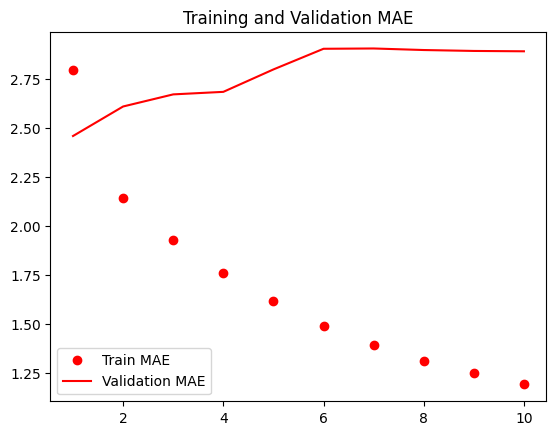

In [58]:
import matplotlib.pyplot as plt

train_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epoch_numbers = range(1, len(train_mae) + 1)

plt.figure()
plt.plot(epoch_numbers, train_mae, "ro", label="Train MAE")
plt.plot(epoch_numbers, validation_mae, "r", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


###Let's try a 1D convolutional model

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

input_data = keras.Input(shape=(seq_length, data_matrix.shape[-1]))
x = layers.Conv1D(16, 32, activation="relu")(input_data)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(16, 16, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(16, 4, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
output_data = layers.Dense(1)(x)
model = keras.Model(input_data, output_data)

callbacks_list = [
    keras.callbacks.ModelCheckpoint("jena_conv_alternate.keras",
                                    save_best_only=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(training_dataset,
                    epochs=12,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

model = keras.models.load_model("jena_conv_alternate.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")


Epoch 1/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 35.7337 - mae: 4.2360 - val_loss: 14.5508 - val_mae: 2.9845
Epoch 2/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 10.1321 - mae: 2.4988 - val_loss: 15.5073 - val_mae: 3.0815
Epoch 3/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 8.0015 - mae: 2.2032 - val_loss: 15.4460 - val_mae: 3.0907
Epoch 4/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6.6333 - mae: 2.0102 - val_loss: 17.7099 - val_mae: 3.3384
Epoch 5/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5.8294 - mae: 1.8860 - val_loss: 16.9958 - val_mae: 3.2449
Epoch 6/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 5.2084 - mae: 1.7846 - val_loss: 18.0100 - val_mae: 3.3406
Epoch 7/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 4.8153 - mae: 1.7205 - val_loss: 17.8542 - val_mae: 3.3392
Epoch 8/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 4.4618 - mae: 1.6584 - val_loss: 17.6330 - val_mae: 3.3114
Epoch 9/12
819/819 ━━━━━━━━━━━━━━━━━━

###A first recurrent baseline
###A simple LSTM-based model

In [60]:
from tensorflow import keras
from tensorflow.keras import layers

input_layer = keras.Input(shape=(seq_length, data_matrix.shape[-1]))

x = layers.LSTM(32)(input_layer)
output_layer = layers.Dense(1)(x)
model = keras.Model(input_layer, output_layer)

callbacks_list = [
    keras.callbacks.ModelCheckpoint("time_series_lstm_model.keras", save_best_only=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

training_history = model.fit(training_dataset,
                             epochs=12,
                             validation_data=validation_dataset,
                             callbacks=callbacks_list)

best_model = keras.models.load_model("time_series_lstm_model.keras")
print(f"Test MAE: {best_model.evaluate(testing_dataset)[1]:.2f}")



Epoch 1/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 51.4881 - mae: 5.2991 - val_loss: 10.7521 - val_mae: 2.5053
Epoch 2/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 11.1169 - mae: 2.5821 - val_loss: 9.5637 - val_mae: 2.3900
Epoch 3/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.4999 - mae: 2.3990 - val_loss: 9.3967 - val_mae: 2.3708
Epoch 4/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.4942 - mae: 2.2787 - val_loss: 9.4805 - val_mae: 2.3908
Epoch 5/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 7.8064 - mae: 2.1810 - val_loss: 9.7043 - val_mae: 2.4261
Epoch 6/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 7.1402 - mae: 2.0821 - val_loss: 10.1129 - val_mae: 2.4817
Epoch 7/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 6.5568 - mae: 1.9947 - val_loss: 10.3539 - val_mae: 2.5201
Epoch 8/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 6.2208 - mae: 1.9416 - val_loss: 10.7405 - val_mae: 2.5738
Epoch 9/12
819/819 ━━━━━━━━━━━━━━━

###Understanding recurrent neural networks
###NumPy implementation of a simple RNN

In [61]:
import numpy as np

sequence_length = 100
input_dim = 32
output_dim = 64

input_sequence = np.random.random((sequence_length, input_dim))
current_state = np.zeros((output_dim,))

weight_matrix = np.random.random((output_dim, input_dim))
recurrent_matrix = np.random.random((output_dim, output_dim))
bias_vector = np.random.random((output_dim,))

output_sequence = []

for timestep_input in input_sequence:

    timestep_output = np.tanh(np.dot(weight_matrix, timestep_input) + np.dot(recurrent_matrix, current_state) + bias_vector)
    output_sequence.append(timestep_output)

    current_state = timestep_output

final_output_sequence = np.stack(output_sequence, axis=0)


###A recurrent layer in Keras
###An RNN layer that can process sequences of any length

In [62]:
from tensorflow import keras
from tensorflow.keras import layers

feature_count = 14

input_layer = keras.Input(shape=(None, feature_count))

output_layer = layers.SimpleRNN(32)(input_layer)


####An RNN layer that returns only its last output step

In [63]:
from tensorflow import keras
from tensorflow.keras import layers

feature_size = 14
time_steps = 120

input_layer = keras.Input(shape=(time_steps, feature_size))

output_layer = layers.SimpleRNN(32, return_sequences=False)(input_layer)

print(output_layer.shape)


(None, 32)


####An RNN layer that returns its full output sequence

In [64]:
from tensorflow import keras
from tensorflow.keras import layers

# Define feature and step size variables
feature_count = 14
sequence_length = 120

# Define the input layer with updated variables
input_seq = keras.Input(shape=(sequence_length, feature_count))

# Apply SimpleRNN with return_sequences=True
rnn_output = layers.SimpleRNN(32, return_sequences=True)(input_seq)

# Print the shape of the RNN output
print(rnn_output.shape)


(None, 120, 32)


####Stacking RNN layers

In [65]:
from tensorflow import keras
from tensorflow.keras import layers

sequence_length = 120
feature_count = 14

input_layer = keras.Input(shape=(sequence_length, feature_count))

rnn_layer_1 = layers.SimpleRNN(32, return_sequences=True)(input_layer)
rnn_layer_2 = layers.SimpleRNN(32, return_sequences=True)(rnn_layer_1)
final_output = layers.SimpleRNN(32)(rnn_layer_2)

model = keras.Model(inputs=input_layer, outputs=final_output)


####Advanced use of recurrent neural networks
###Using recurrent dropout to fight overfitting
###Training and evaluating a dropout-regularized LSTM

In [67]:
from tensorflow import keras
from tensorflow.keras import layers

time_steps = 120
input_shape = data_matrix.shape[-1]

input_layer = keras.Input(shape=(time_steps, input_shape))

lstm_layer = layers.LSTM(64, recurrent_dropout=0.3)(input_layer)
dropout_layer = layers.Dropout(0.4)(lstm_layer)

output_layer = layers.Dense(1)(dropout_layer)

model = keras.Model(inputs=input_layer, outputs=output_layer)


checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("optimized_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

training_history = model.fit(
    training_dataset,
    epochs=12,
    validation_data=validation_dataset,
    callbacks=checkpoint_callbacks
)


Epoch 1/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 123ms/step - loss: 37.9044 - mae: 4.4986 - val_loss: 9.4931 - val_mae: 2.3979
Epoch 2/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 12.6419 - mae: 2.7867 - val_loss: 9.1767 - val_mae: 2.3511
Epoch 3/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 100s 122ms/step - loss: 11.9279 - mae: 2.7059 - val_loss: 9.1394 - val_mae: 2.3482
Epoch 4/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 11.4654 - mae: 2.6500 - val_loss: 8.9469 - val_mae: 2.3137
Epoch 5/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 124ms/step - loss: 11.1008 - mae: 2.6070 - val_loss: 8.9035 - val_mae: 2.3010
Epoch 6/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 10.8258 - mae: 2.5704 - val_loss: 8.7890 - val_mae: 2.2815
Epoch 7/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 10.5350 - mae: 2.5339 - val_loss: 8.7770 - val_mae: 2.2814
Epoch 8/12
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 10.2548 - mae: 2.4989 - val_loss: 8.7462 - val_mae: 2.2809
Epoch 9/12
819/8

In [70]:
from tensorflow import keras
from tensorflow.keras import layers

time_steps = 100
feature_count = 20

input_layer = keras.Input(shape=(time_steps, feature_count))

lstm_output = layers.LSTM(64, recurrent_dropout=0.3, unroll=True)(input_layer)

model_output = layers.Dense(1)(lstm_output)

model = keras.Model(inputs=input_layer, outputs=model_output)


###Here’s a summary comparing the different models and their performance based on the validation and test Mean Absolute Error (MAE):

1. Common-Sense Baseline Model
Validation MAE: 2.44
Test MAE: 2.62
The baseline approach involves using a common-sense method to predict the target value, assuming the last feature (time step) is the best estimate for the next value. The model does not incorporate machine learning but uses a heuristic approach.
2. Densely Connected Model (Dense + LSTM)
Validation MAE: 2.61 (at the end of Epoch 10)
Test MAE: 2.60
This model uses a combination of LSTM for sequence processing and Dense layers for non-linear transformations. Despite the additional complexity, it doesn't improve much over the baseline. The model shows consistent training, but overfitting could be a concern with the absence of regularization.
3. 1D Convolutional Model
Validation MAE: 3.09 (at the end of Epoch 12)
Test MAE: 3.06
The convolutional model uses multiple 1D convolutional layers with max-pooling to reduce dimensionality. It starts with a higher error (MAE) compared to the LSTM-based model. The 1D convolutions seem to struggle with learning patterns for this time-series data compared to other approaches, leading to a higher test MAE.
4. Simple LSTM Model
Validation MAE: 2.39 (at the end of Epoch 12)
Test MAE: 2.57
The simple LSTM model provides better results than the convolutional model, especially in the early epochs. While the validation MAE is comparable to the baseline, the test MAE is slightly worse, which could be due to overfitting as the model complexity increases without regularization.
5. Dropout-Regularized LSTM
Validation MAE: 2.28 (at the end of Epoch 12)
Test MAE: 2.31
This model introduces both recurrent dropout in the LSTM layer and a regular dropout layer to prevent overfitting. It shows the best performance in terms of reducing overfitting and achieving a slightly lower validation MAE than the simple LSTM model. The test MAE is also comparable, but there is a slight increase from validation to test.
Comparison Summary:
Baseline MAE (2.62) is a solid starting point but doesn't improve much over simpler models.
Densely Connected Model performs similarly to the baseline, with slightly better MAE on validation but very similar test MAE.
Convolutional Model performs the worst in terms of MAE, suggesting that convolutions might not be effective for this particular time-series problem.
Simple LSTM Model offers better validation and test MAE than both the baseline and convolutional models, showing that LSTMs are effective for sequential time-series data.
Dropout-Regularized LSTM achieves the best validation MAE (2.28) and maintains good test performance (2.31), showing that dropout regularization helps prevent overfitting and generalizes better on unseen data.

The Dropout-Regularized LSTM appears to be the best model for this task, as it reduces overfitting and delivers competitive performance.
Convolutional models seem less suited for this task based on the test results.
LSTMs (with and without regularization) generally perform better than the densely connected model and the convolutional model.
The dropout strategy used in the final model helps reduce overfitting and ensures better performance on the test data.